In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sscCdi
import sscRaft 

from matplotlib.colors import LogNorm                                                                                                           
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale, resize, downscale_local_mean

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from multiprocessing import Pool, cpu_count

# Construct example volume
### The ssCdi + sscRaft tomography pipeline only works with the phase or amplitude individually 

## Some definitions

In [2]:
N = 192#1710
N_sample = int((512/1500)*N)
fix =   N_sample %2 
zoom = (0.2*512)/N_sample

radius_sample = 0.31
shift_sample = 0.2
 
fix = 0 

In [3]:
def create_2d_text_image(text, image_size, font_size=100):
    """Create a 2D image with the given text."""
    image = Image.new('L', image_size, 0)  # Create a black image
    draw = ImageDraw.Draw(image)
    
    # If truetype font is not available, use default
    font = ImageFont.load_default()
    # Calculate width and height of the text to center it
    text_width, text_height = draw.textsize(text, font=font)
    position = ((image_size[1] - text_width) // 2, (image_size[0] - text_height) // 2)
    
    draw.text(position, text, fill=255, font=font, font_size = font_size)  # Draw white text
    
    return np.array(image)

def create_3d_volume_from_2d(image_2d, depth=1):
    """Create a 3D volume from a 2D image by repeating the image along a new axis."""
    volume_3d = np.repeat(image_2d[np.newaxis,:, :], depth, axis=0)
    volume_3d[:image_2d.shape[0]//3,:,:] = 0
    volume_3d[int(2*image_2d.shape[0]/3)::,:,:] = 0
    return volume_3d


### create observed data for the phase using the GCC phantom


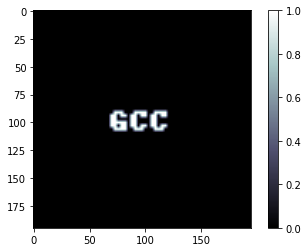

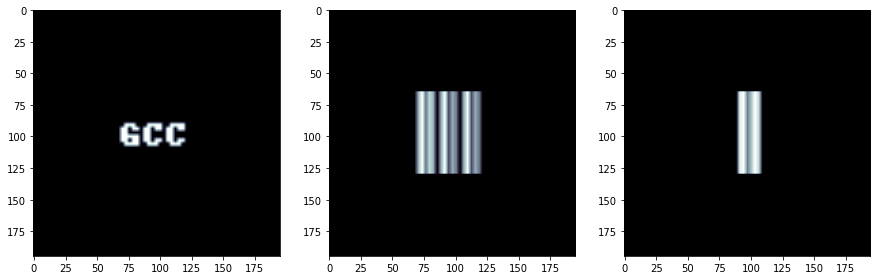

In [4]:
# Create a 2D image with the text "GCC"
text_image = create_2d_text_image("GCC", image_size=(N_sample,N_sample))
#text_image = np.invert(text_image)
text_image = rescale(text_image,3, mode='constant', cval= 0)
plt.imshow(text_image,cmap='bone')
plt.colorbar()
plt.show()
# Create a 3D volume from the 2D image
phase_sample = create_3d_volume_from_2d(text_image, depth=text_image.shape[0])

# visu support 
fig, axs = plt.subplots(1,3, figsize=(15,7));
axs[0].imshow(phase_sample.sum(0),cmap='bone');
# axs[0].axis('off');

axs[1].imshow(phase_sample.sum(1),cmap='bone');
# axs[1].axis('off');

axs[2].imshow(phase_sample.sum(2),cmap='bone');
# axs[2].axis('off');
plt.show()

### Reproject the volume to obtain the projections obtained in tomo experiment

In [5]:
N_projections = 100
angles = (np.pi/180)*np.linspace(-90,90, N_projections)
print(angles)

projections = sscRaft.radon_RT(phase_sample,angles, gpus = [0], pixel =1)
projections = np.swapaxes(projections, 0, 1)
print(projections.shape)

#make it a phase obj

projections = (projections-projections.min())/(projections.max()-projections.min())*np.pi# -np.pi
for i, frame in enumerate(projections):
    projections[i] = np.amax(frame)  - frame

[-1.57079633 -1.53906307 -1.50732981 -1.47559655 -1.44386329 -1.41213003
 -1.38039677 -1.34866351 -1.31693025 -1.28519699 -1.25346374 -1.22173048
 -1.18999722 -1.15826396 -1.1265307  -1.09479744 -1.06306418 -1.03133092
 -0.99959766 -0.9678644  -0.93613114 -0.90439789 -0.87266463 -0.84093137
 -0.80919811 -0.77746485 -0.74573159 -0.71399833 -0.68226507 -0.65053181
 -0.61879855 -0.58706529 -0.55533203 -0.52359878 -0.49186552 -0.46013226
 -0.428399   -0.39666574 -0.36493248 -0.33319922 -0.30146596 -0.2697327
 -0.23799944 -0.20626618 -0.17453293 -0.14279967 -0.11106641 -0.07933315
 -0.04759989 -0.01586663  0.01586663  0.04759989  0.07933315  0.11106641
  0.14279967  0.17453293  0.20626618  0.23799944  0.2697327   0.30146596
  0.33319922  0.36493248  0.39666574  0.428399    0.46013226  0.49186552
  0.52359878  0.55533203  0.58706529  0.61879855  0.65053181  0.68226507
  0.71399833  0.74573159  0.77746485  0.80919811  0.84093137  0.87266463
  0.90439789  0.93613114  0.9678644   0.99959766  1.

### Visualize some projections and sinogram

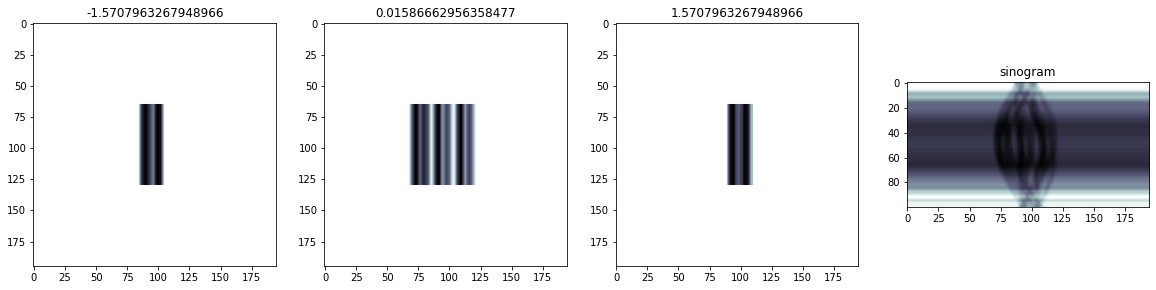

In [6]:
fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(projections[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(projections[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(projections[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(projections, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram")    
plt.show()

### Apply jitter to the data

In [7]:
jitters = np.random.randint(-10,10,(N_projections,2))
sinogram = projections.copy()
for i in range(N_projections):
    sinogram[i] = scipy.ndimage.shift(projections[i],(jitters[i,0],jitters[i,1]),mode = 'reflect')

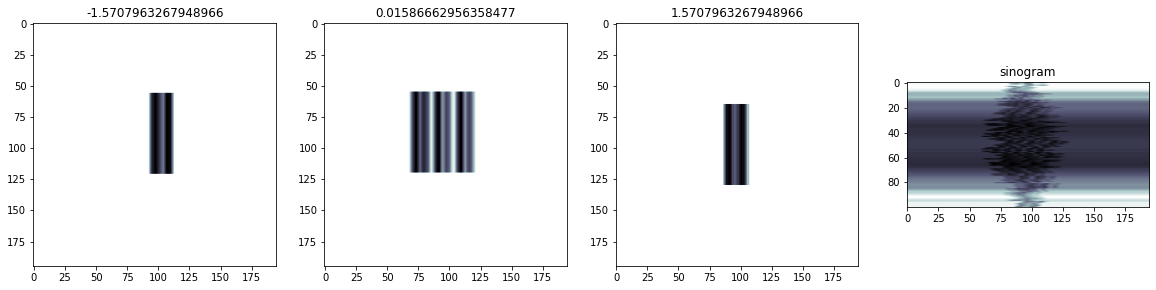

In [8]:
fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram")    
plt.show()

# Tomo recon

### Crop data

Cropped sinogram shape: (100, 175, 175)
Time elapsed: 0.00 s


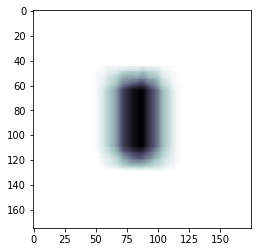

In [9]:
top_crop    = 10    # n of pixels to remove on top
bottom_crop = 10    # n of pixels to remove on bottom
left_crop   = 10    # n of pixels to remove on left
right_crop  = 10    # n of pixels to remove on right

sinogram = sscCdi.processing.crop_volume(sinogram, top_crop, bottom_crop, left_crop, right_crop)
plt.imshow(sinogram.sum(0),cmap='bone')
plt.show()

### Remove bad projections

In [10]:
bad_frames = []
sinogram, angles = sscCdi.remove_frames_from_sinogram(sinogram,angles,bad_frames)

Original shape:  (100, 175, 175)
New shape:  (100, 175, 175)


### Sort data

In [11]:
sinogram, angles = sscCdi.sort_sinogram_by_angle(sinogram, angles) 
sort_index = angles[:,0]
angles = angles[:,1]
print(angles)

Time elapsed: 0.00 s
[-1.57079633 -1.53906307 -1.50732981 -1.47559655 -1.44386329 -1.41213003
 -1.38039677 -1.34866351 -1.31693025 -1.28519699 -1.25346374 -1.22173048
 -1.18999722 -1.15826396 -1.1265307  -1.09479744 -1.06306418 -1.03133092
 -0.99959766 -0.9678644  -0.93613114 -0.90439789 -0.87266463 -0.84093137
 -0.80919811 -0.77746485 -0.74573159 -0.71399833 -0.68226507 -0.65053181
 -0.61879855 -0.58706529 -0.55533203 -0.52359878 -0.49186552 -0.46013226
 -0.428399   -0.39666574 -0.36493248 -0.33319922 -0.30146596 -0.2697327
 -0.23799944 -0.20626618 -0.17453293 -0.14279967 -0.11106641 -0.07933315
 -0.04759989 -0.01586663  0.01586663  0.04759989  0.07933315  0.11106641
  0.14279967  0.17453293  0.20626618  0.23799944  0.2697327   0.30146596
  0.33319922  0.36493248  0.39666574  0.428399    0.46013226  0.49186552
  0.52359878  0.55533203  0.58706529  0.61879855  0.65053181  0.68226507
  0.71399833  0.74573159  0.77746485  0.80919811  0.84093137  0.87266463
  0.90439789  0.93613114  0.967

## unwrap, reescale and equalize if necessary 

Using 32 CPUs
Using 32 parallel processes


100%|██████████| 100/100 [00:00<00:00, 1773.08it/s]


Time elapsed: 0.56 s


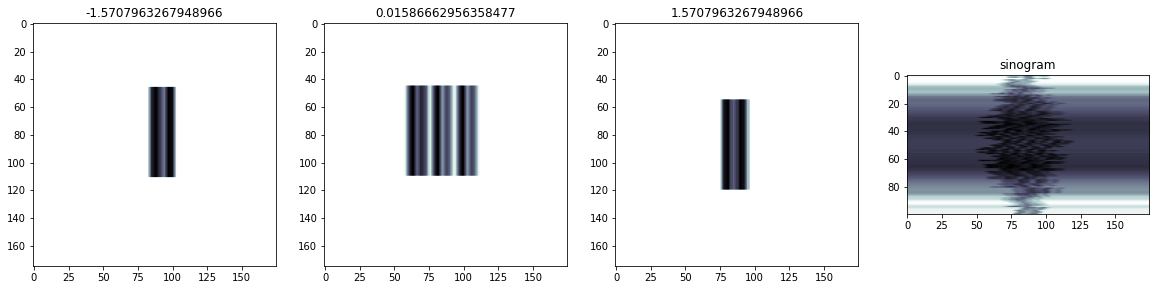

In [12]:
sinogram = sscCdi.unwrap_sinogram(sinogram)
fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram")    
plt.show()

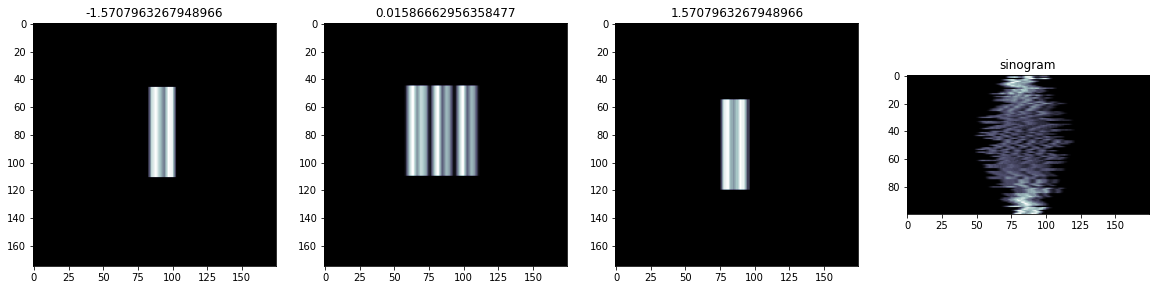

In [13]:
minimum_phase = np.amin(sinogram)   
for i, frame in enumerate(sinogram):
    frame = frame - minimum_phase
    sinogram[i] = np.amax(frame) - frame 
    
fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram")    
plt.show()


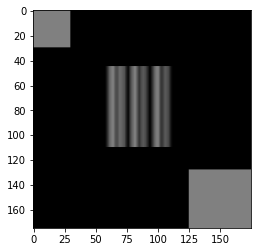

Equalizing frames: 100%|██████████| 100/100 [00:00<00:00, 272.78it/s]
Populating result matrix: 100it [00:00, 12295.68it/s]


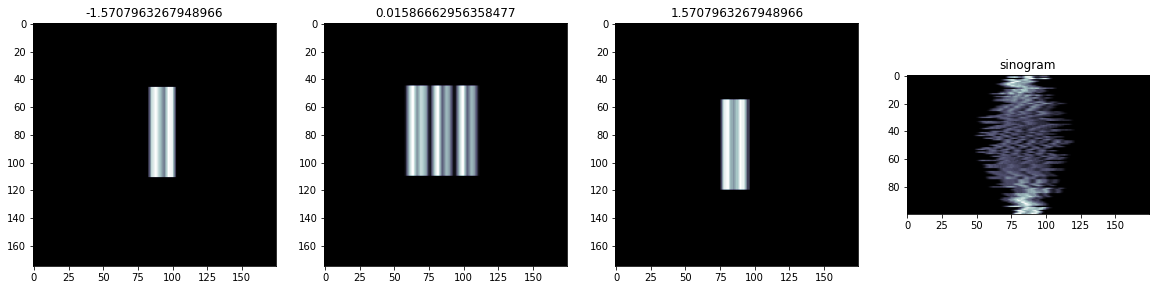

In [14]:
mask_norm = np.zeros(sinogram[50].shape)
mask_norm[0:30,0:30] = 1
mask_norm[128:,125:] = 1

plt.imshow(mask_norm,cmap = 'gray')
plt.imshow(sinogram[50],cmap = 'gray',alpha=0.5)

plt.show()

sinogram = sscCdi.equalize_scipy_optimization_parallel(sinogram,mask_norm,initial_guess=(0,0,0),method='Powell',max_iter = 1,stop_criteria=(1e-3,1e-3,1e-2))

fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram")    
plt.show()


## Aligments 

### Alignment Cross Correlation (CC)


Shifting slices using 256 workers:  99%|█████████▉| 99/100 [00:00<00:00, 4191.81it/s]


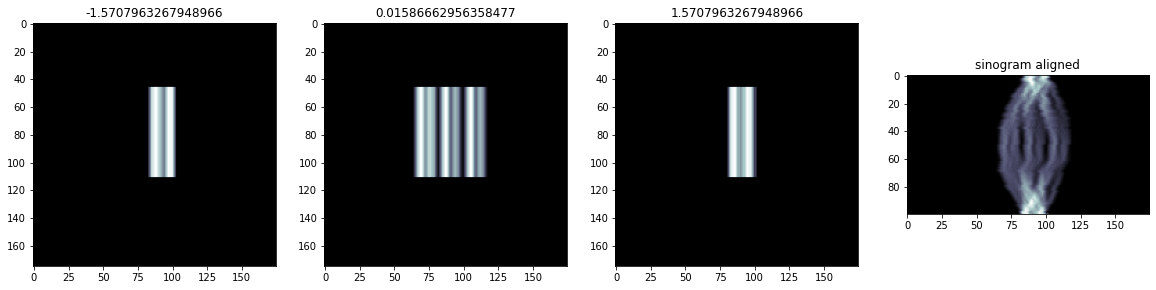

In [15]:
# Find shifts

sinogram, neighbor_shifts, total_shift = sscRaft.processing.alignment_cross_correlation(sinogram,
                                                                                         angles,
                                                                                         fft_upsampling = 1,
                                                                                         max_downscaling_factor = 1, 
                                                                                         stop_at_downscaling=None,
                                                                                         downscaling_method='skip_pixels',
                                                                                         use_gradient= False,
                                                                                         remove_null_borders=False,
                                                                                         threshold=1,
                                                                                         plot=False,
                                                                                         plot_type='phase') 


fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram aligned")    
plt.show()

## Iterative Reprojection

Using 32 CPUs


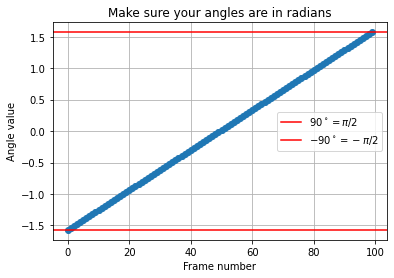

As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 175, 175). Adjusting shape to (100, 174, 174) 

Reconstructing and reprojecting from input data...
Reconstructing...
2025-04-28 14:40:11,430 - sscRaft.rafttypes - INFO - Using default padding: 2.
2025-04-28 14:40:11,431 - sscRaft.rafttypes - INFO - Using default beamgeometry: parallel.
2025-04-28 14:40:11,431 - sscRaft.rafttypes - INFO - Using default interpolation: bilinear.
2025-04-28 14:40:11,431 - sscRaft.rafttypes - INFO - Using default blocksize: 0.
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.00037244
	  gpu_memory: 39.5
	  Blocksize: 174
Reprojecting...
2025-04-28 14:40:11,493 - sscRaft.rafttypes - INFO - Finished Radon RT method


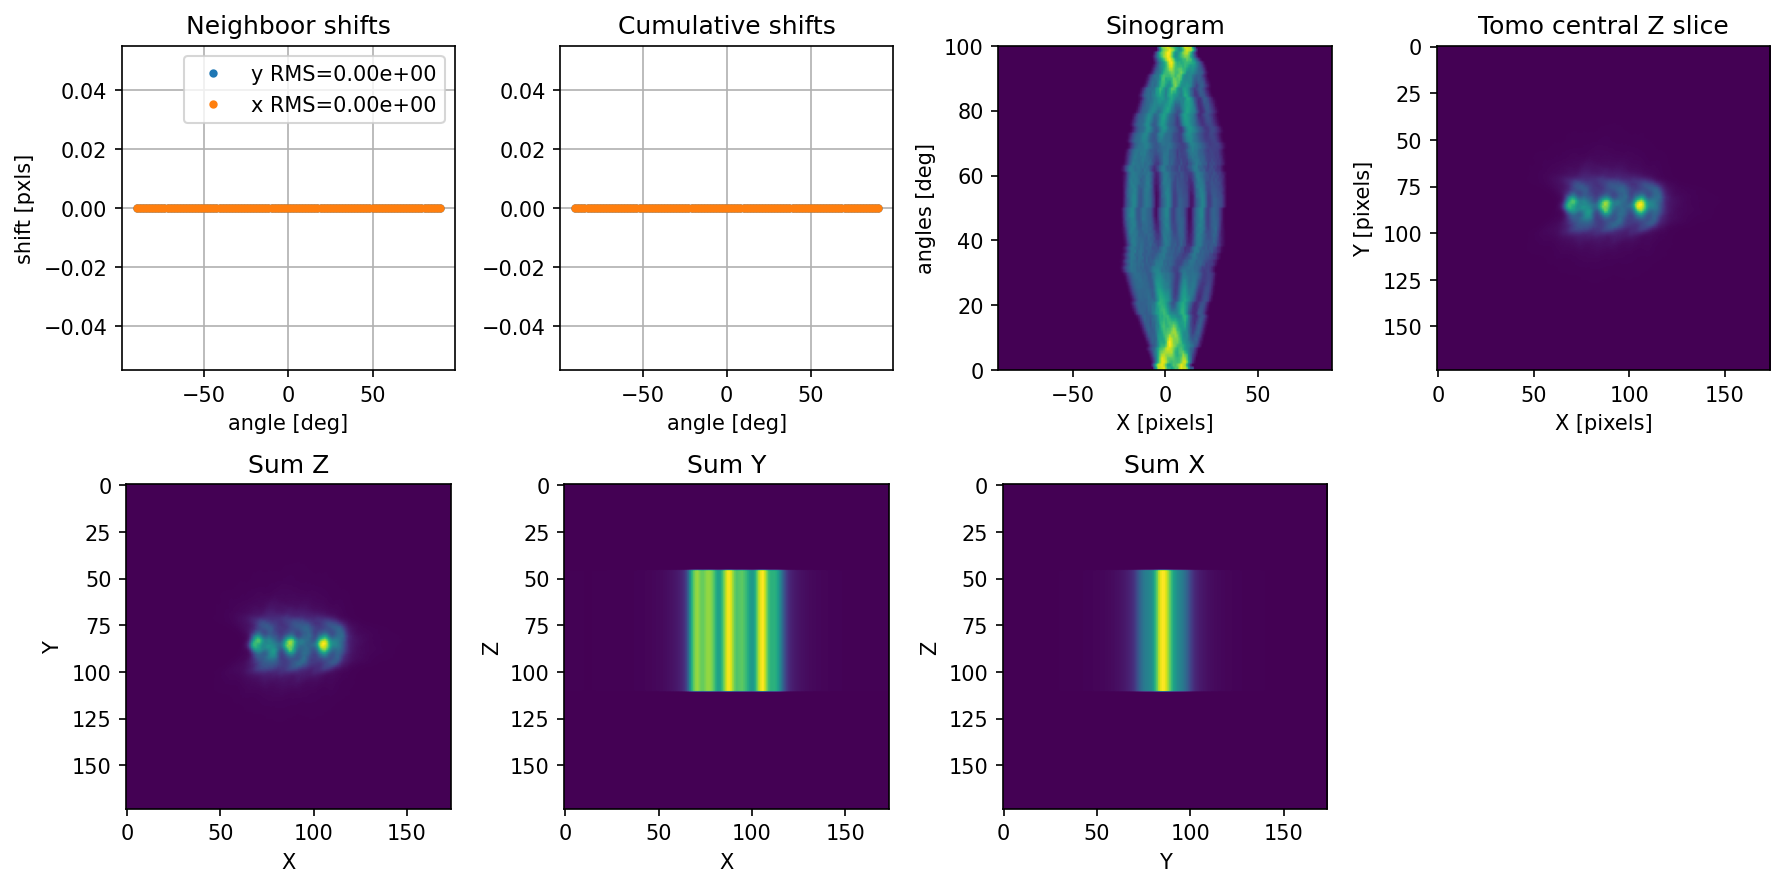

Downsampling data 1 times...
Iteration # 1
Finding shifts...
Applying shifts...
As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 161, 151). Adjusting shape to (100, 160, 150) 

Reconstructing and reprojecting...
Reconstructing...
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000307709
	  gpu_memory: 39.5
	  Blocksize: 160
Reprojecting...
2025-04-28 14:40:21,305 - sscRaft.rafttypes - INFO - Finished Radon RT method


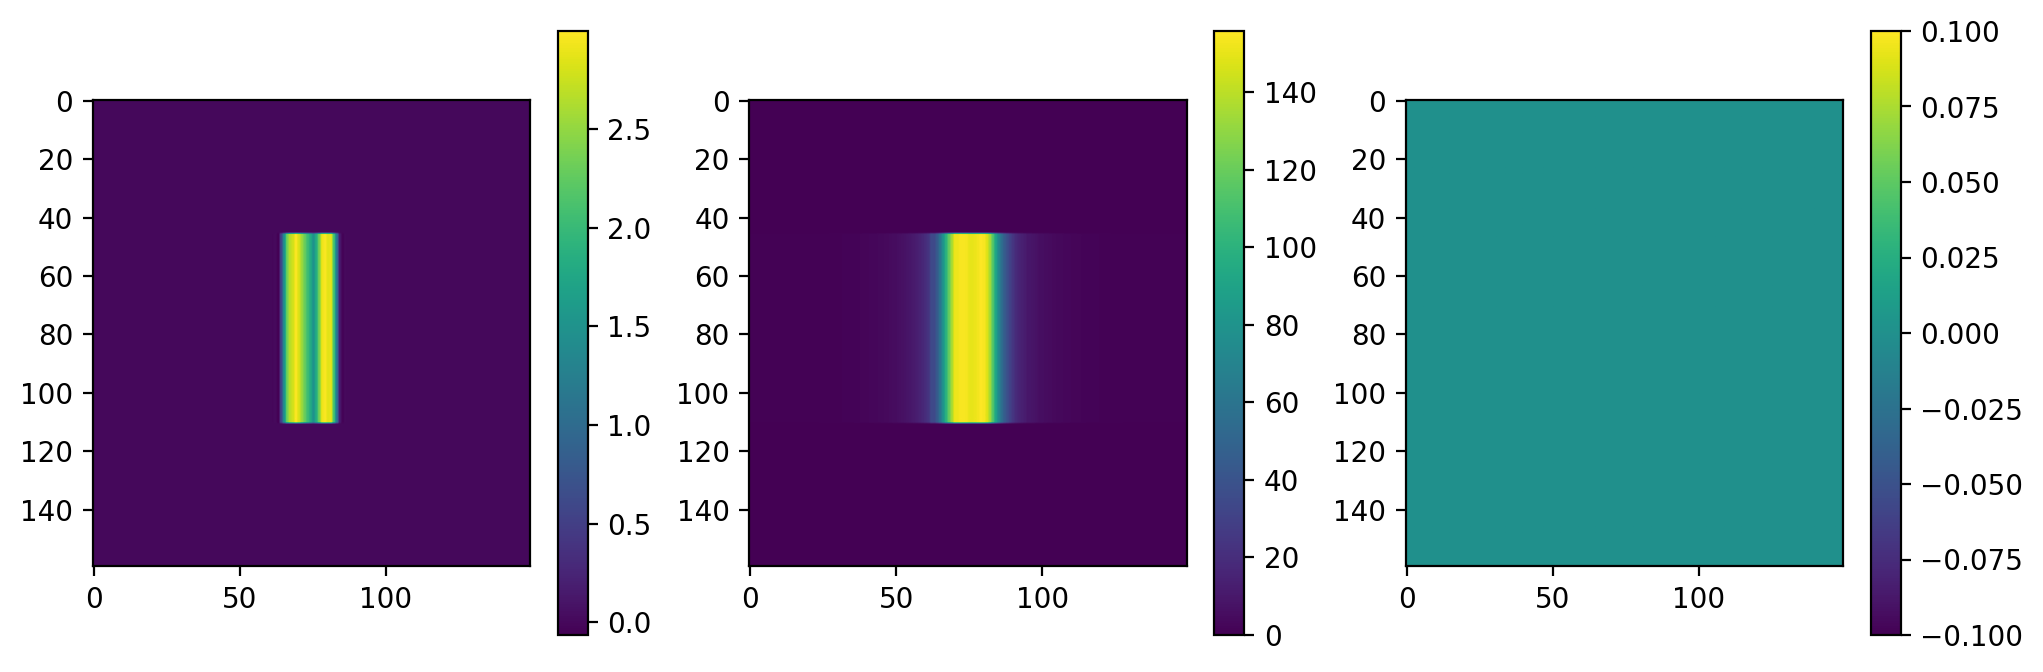

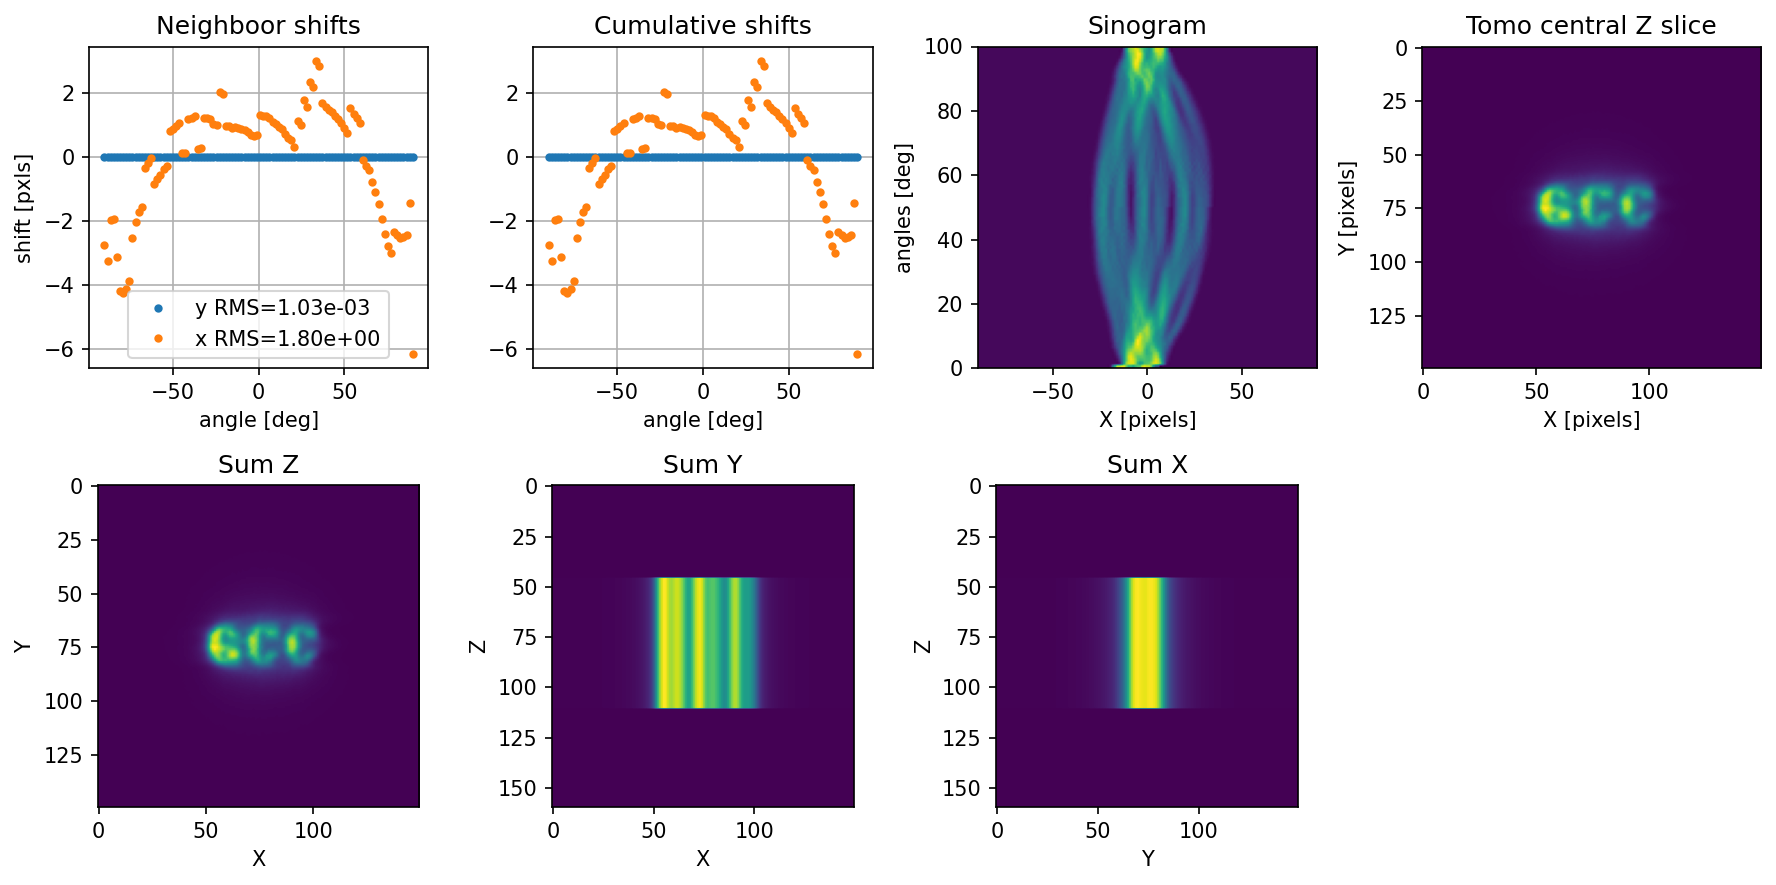

Iteration # 2
Finding shifts...
Applying shifts...
As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 173, 167). Adjusting shape to (100, 172, 166) 

Reconstructing and reprojecting...
Reconstructing...
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000350386
	  gpu_memory: 39.5
	  Blocksize: 172
Reprojecting...
2025-04-28 14:40:35,919 - sscRaft.rafttypes - INFO - Finished Radon RT method


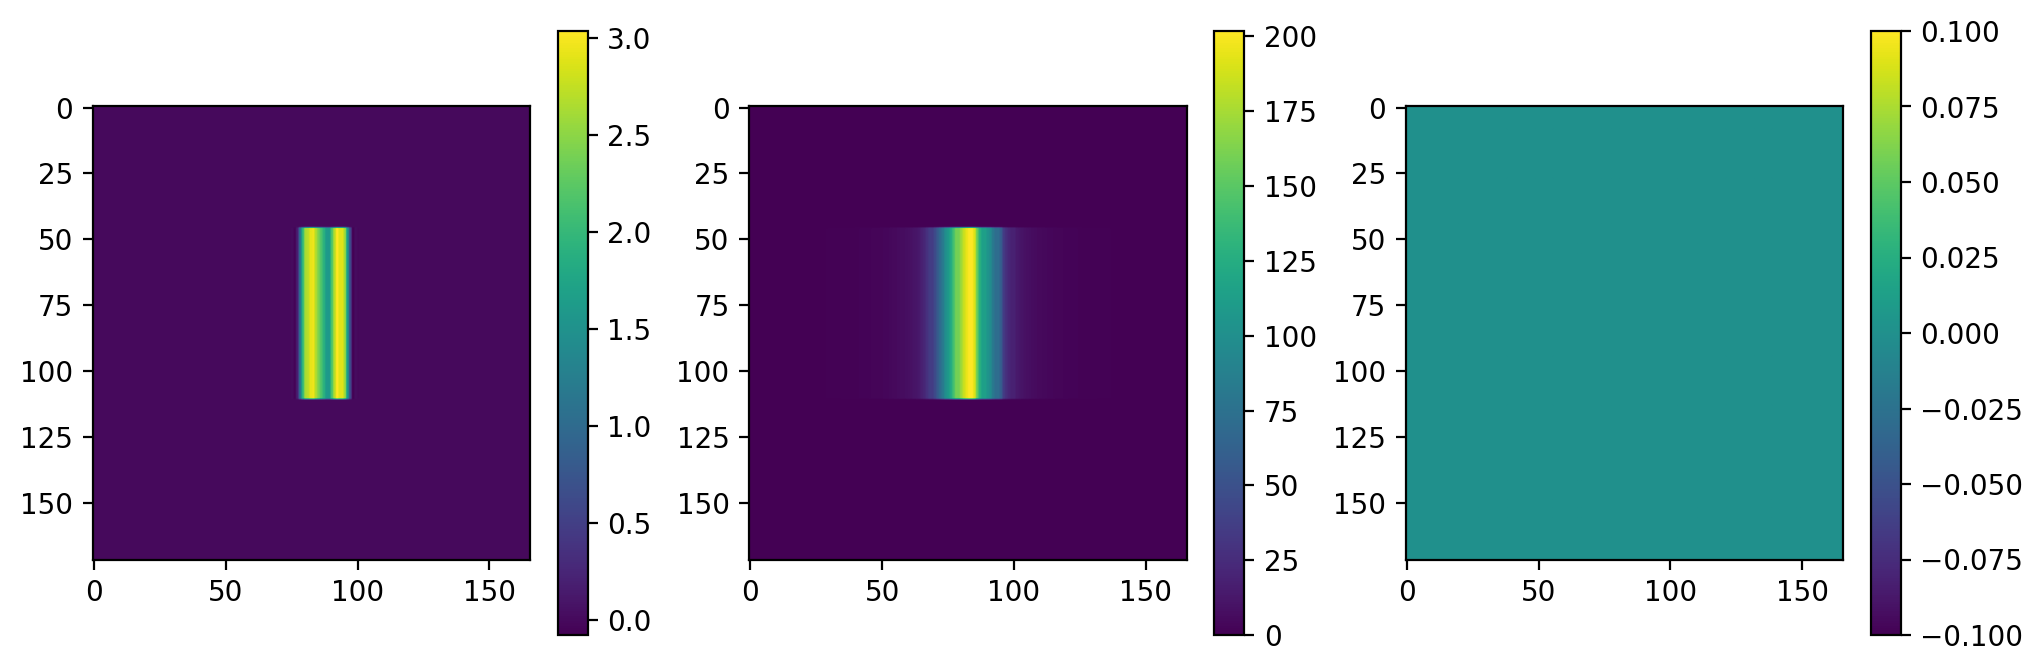

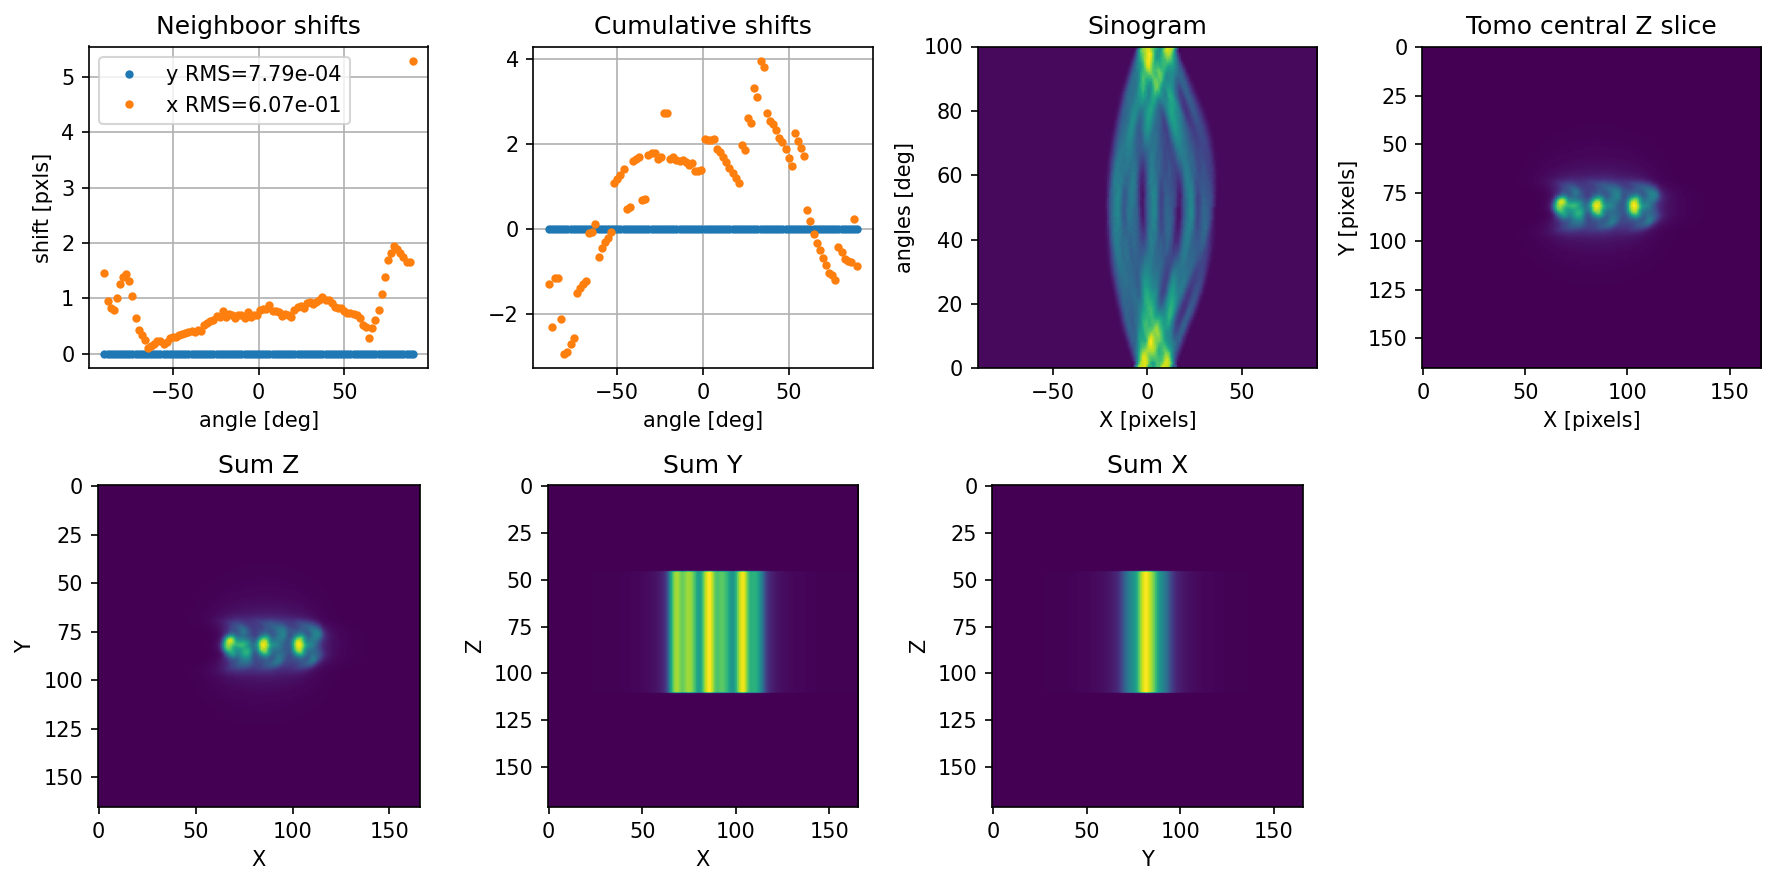

Iteration # 3
Finding shifts...
Applying shifts...
As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 173, 161). Adjusting shape to (100, 172, 160) 

Reconstructing and reprojecting...
Reconstructing...
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000334159
	  gpu_memory: 39.5
	  Blocksize: 172
Reprojecting...
2025-04-28 14:40:48,423 - sscRaft.rafttypes - INFO - Finished Radon RT method


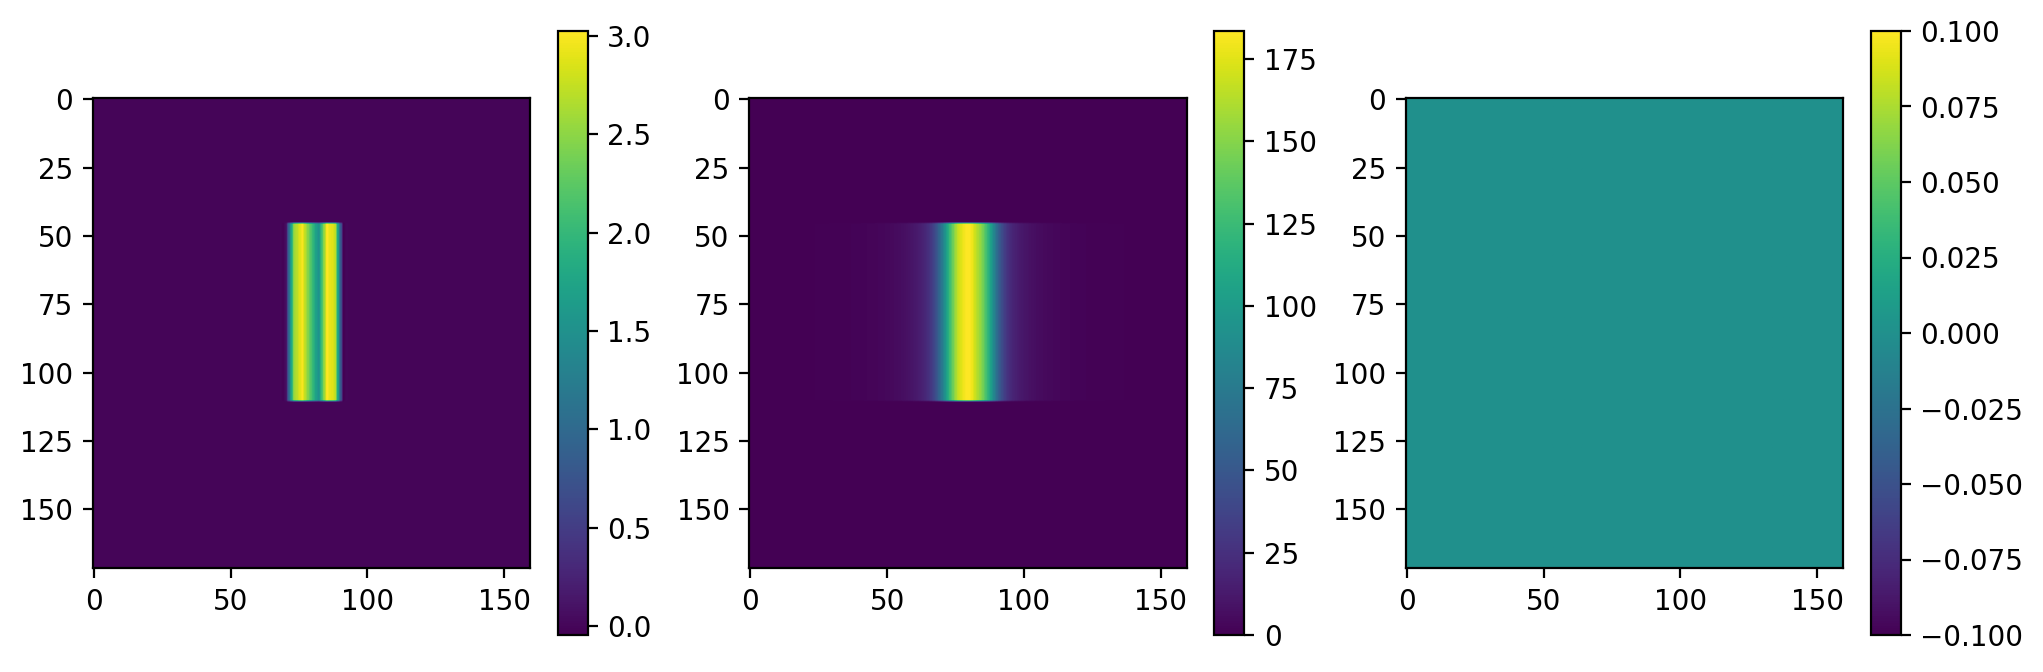

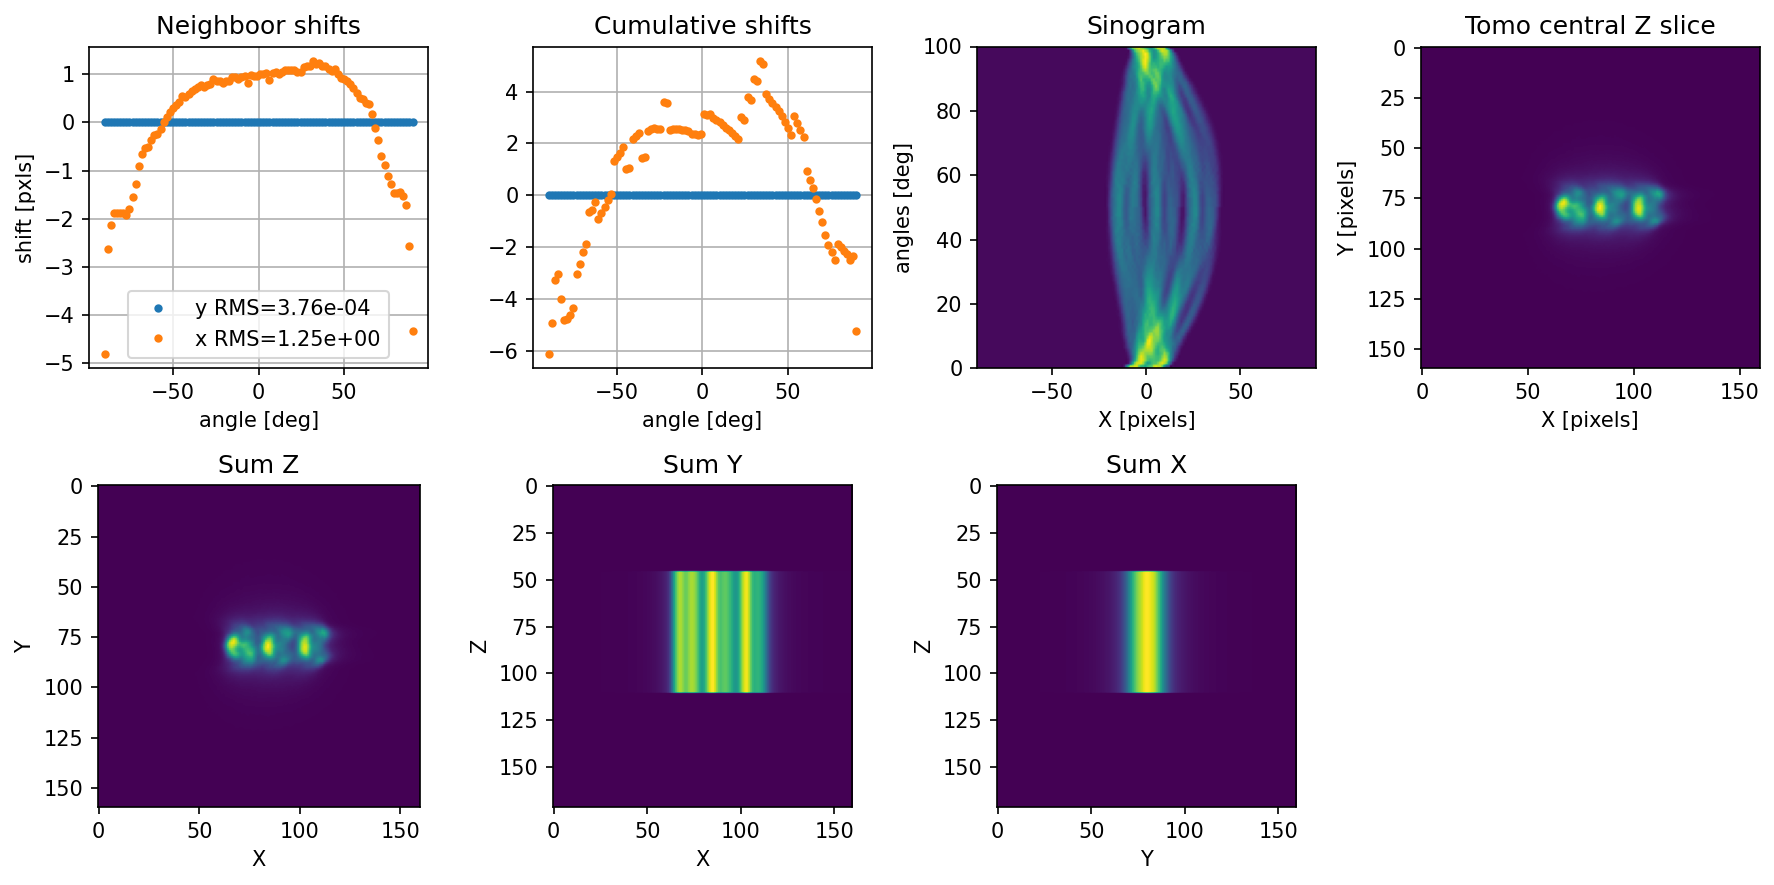

Iteration # 4
Finding shifts...
Applying shifts...
As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 173, 160). Adjusting shape to (100, 172, 160) 

Reconstructing and reprojecting...
Reconstructing...
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000334159
	  gpu_memory: 39.5
	  Blocksize: 172
Reprojecting...
2025-04-28 14:41:01,645 - sscRaft.rafttypes - INFO - Finished Radon RT method


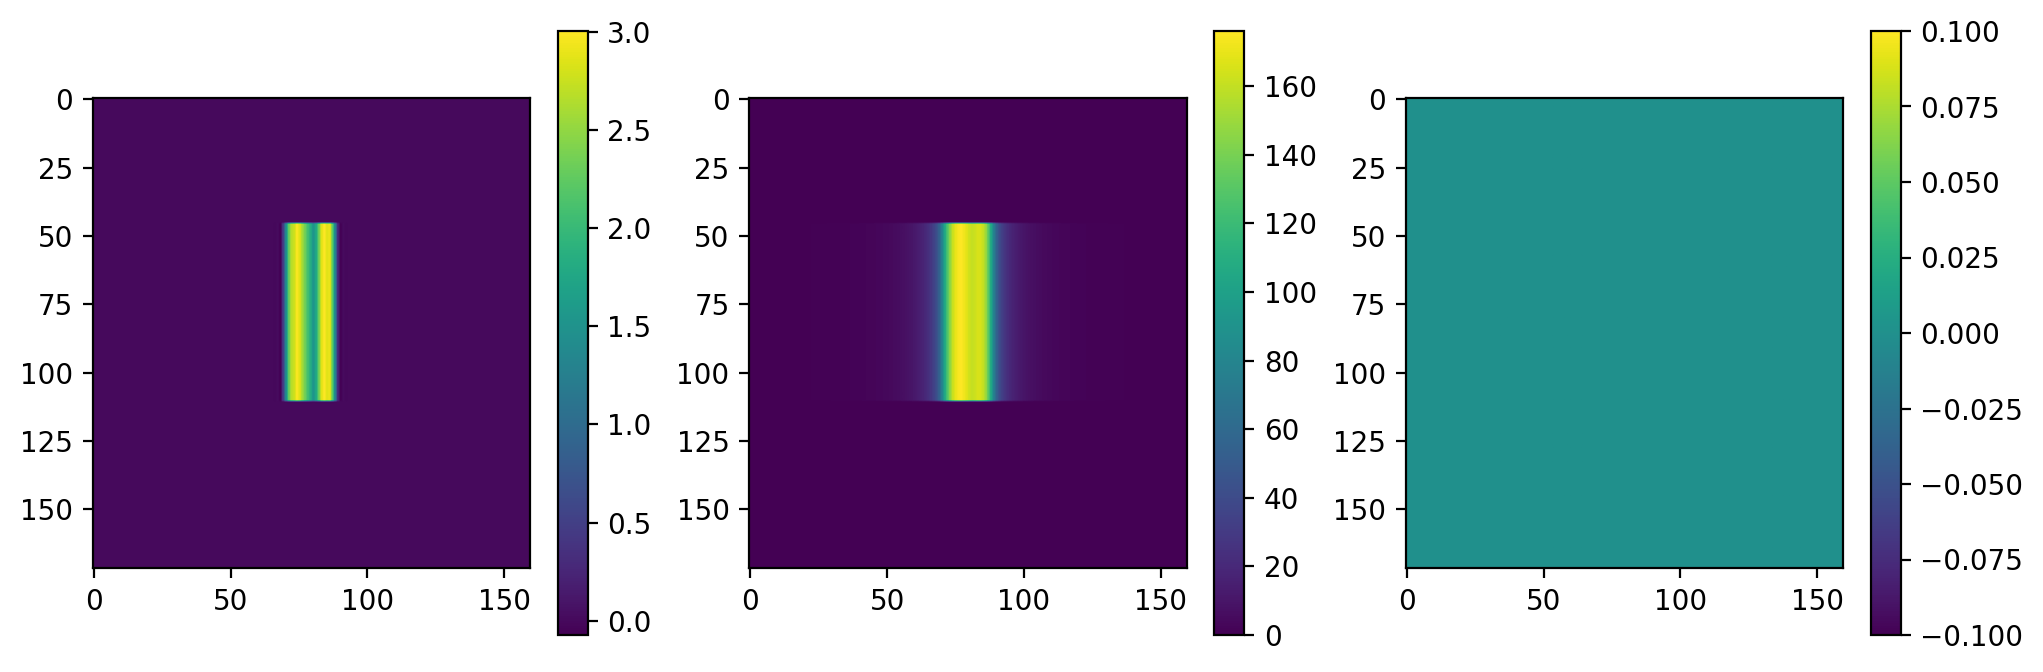

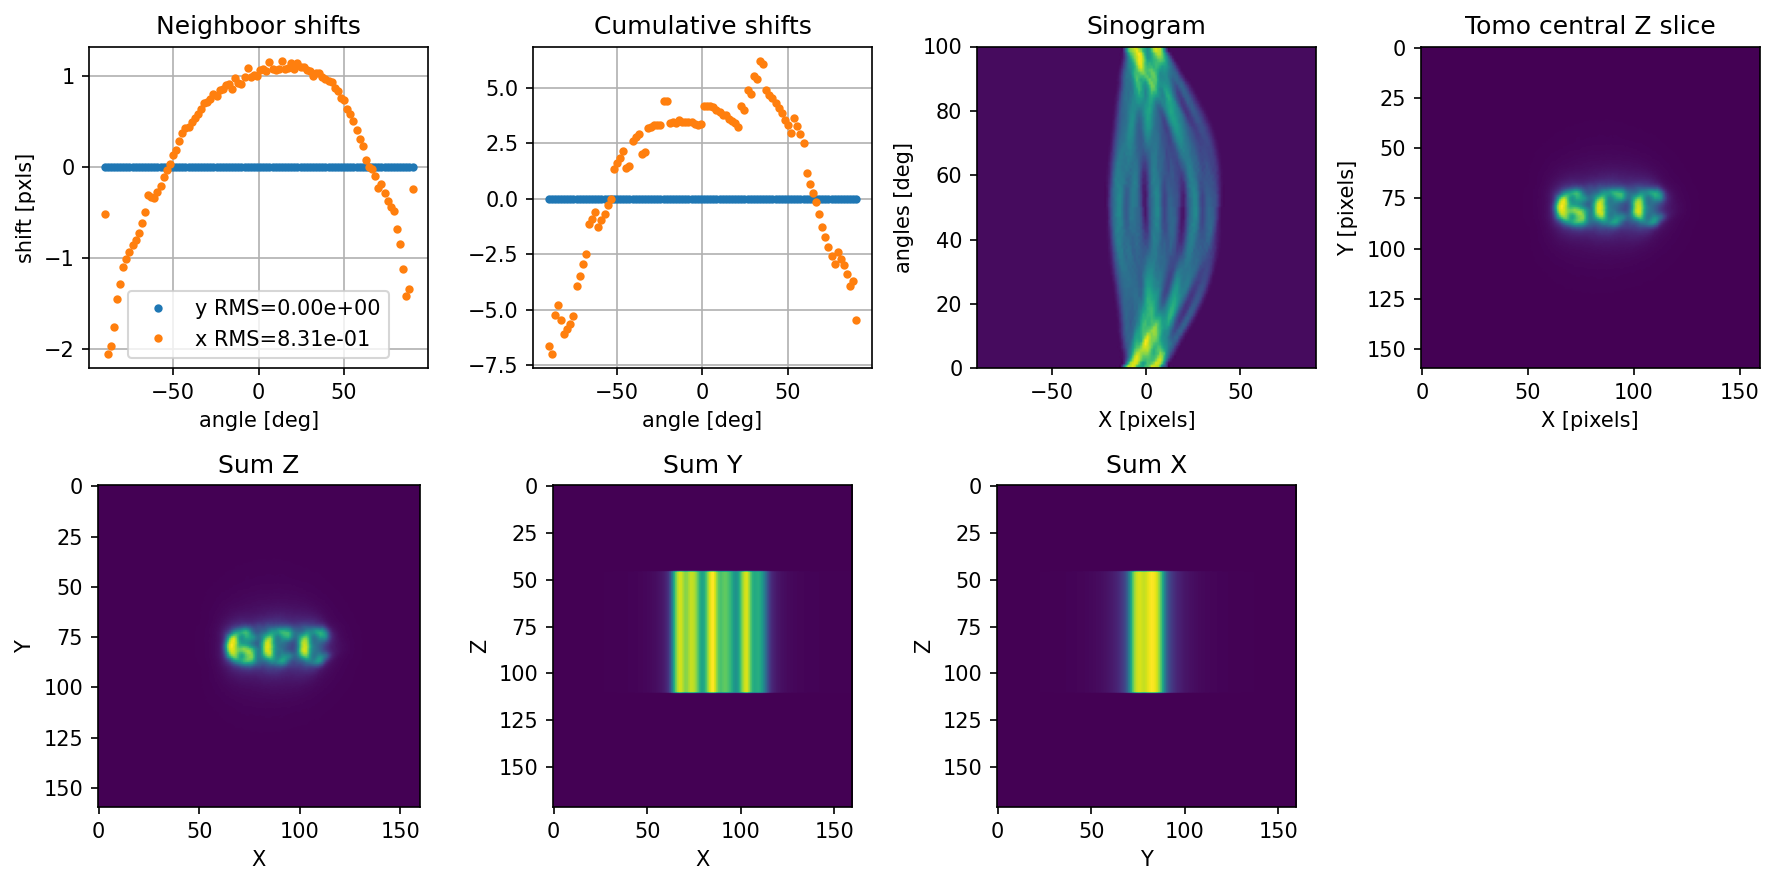

Iteration # 5
Finding shifts...
Applying shifts...
As of now, filtering in sscRaft requires an array with even pixels. Your array shape is (100, 173, 159). Adjusting shape to (100, 172, 158) 

Reconstructing and reprojecting...
Reconstructing...
Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000328809
	  gpu_memory: 39.5
	  Blocksize: 172
Reprojecting...
2025-04-28 14:41:18,459 - sscRaft.rafttypes - INFO - Finished Radon RT method


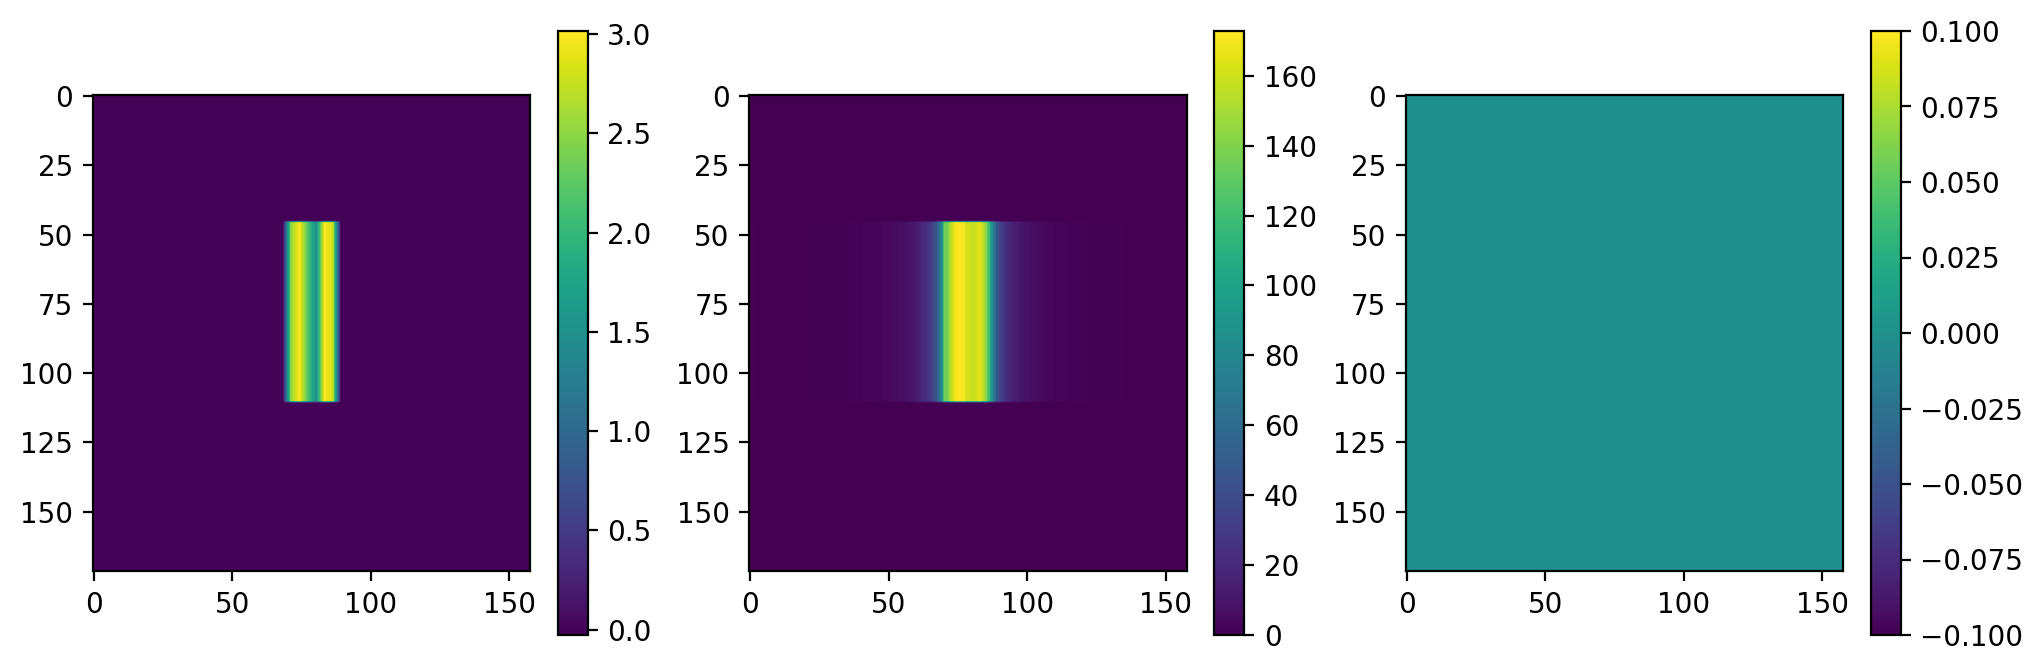

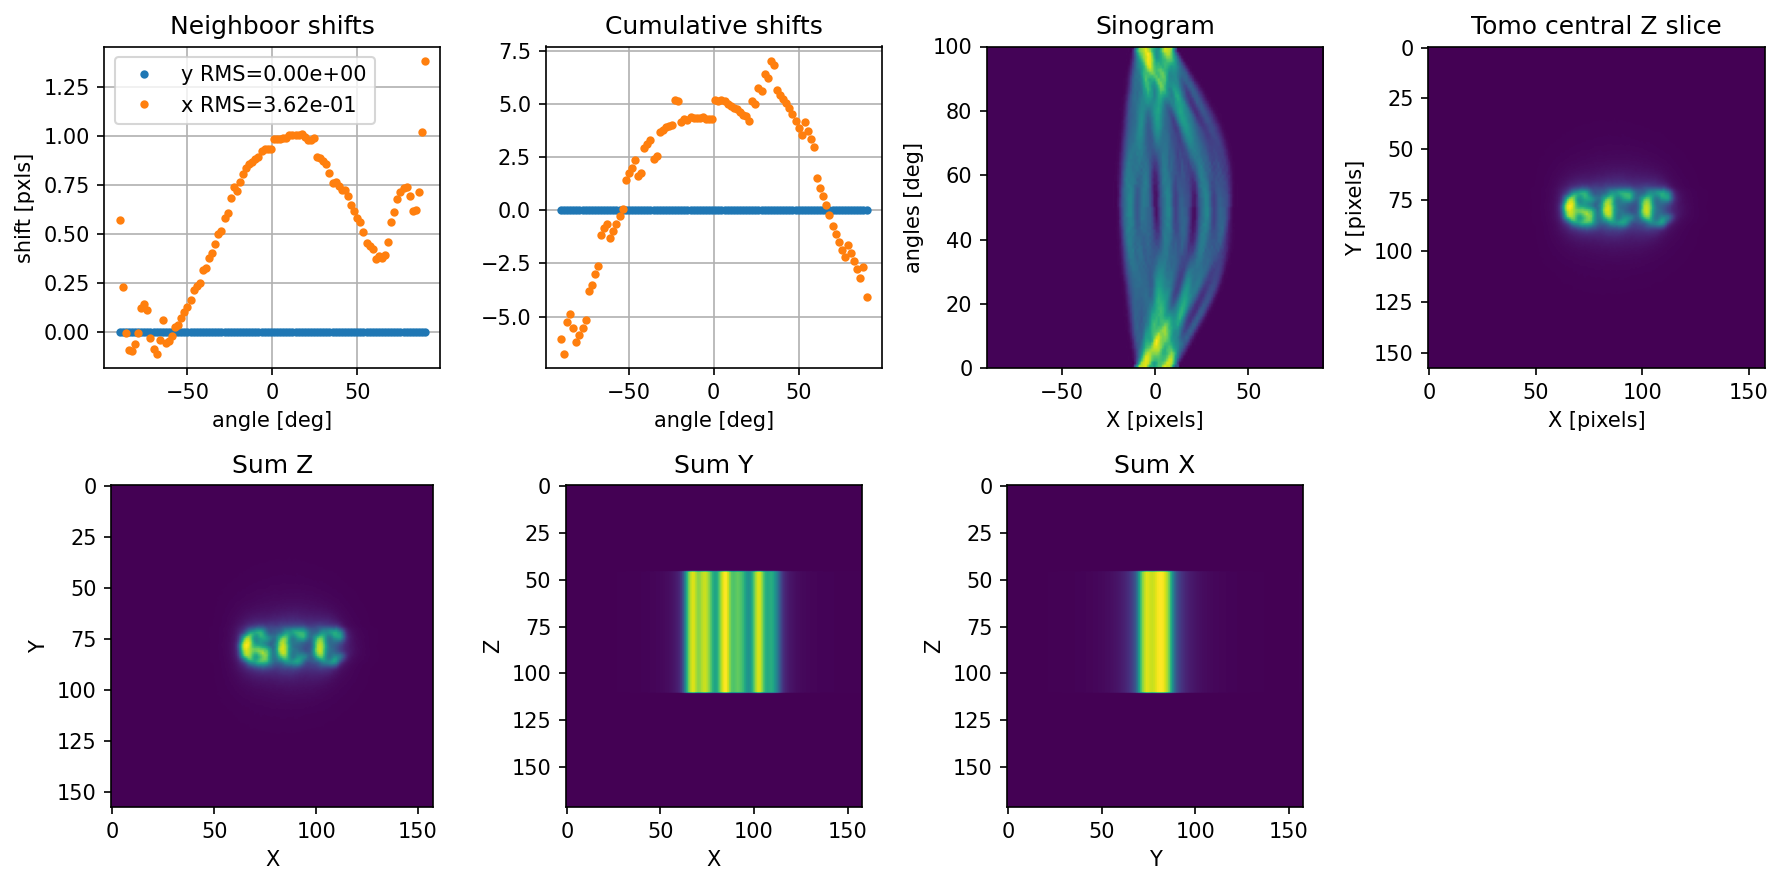

Calculating blocksize...
	  total_required_mem_per_slice GB: 0.000328809
	  gpu_memory: 39.5
	  Blocksize: 172


In [16]:
aligned_volume, sinogram, cumulative_shift, reprojected_sinogram = sscRaft.iterative_reprojection(sinogram, 
                                                                                                  angles, 
                                                                                                   pixel = 1,
                                                                                                   plot = True,                      # plot the progress for each iteration
                                                                                                   n_cpus = 32,                      # number of cpus cthreads utilized
                                                                                                   using_phase_derivative = False,   # uses the derivative of the phase for the aligment 
                                                                                                   threshold = 0.1,                 # minimum value of the mean shift 
                                                                                                   max_iterations = 5,              # maximum number of interations
                                                                                                   max_downsampling = 1,             # reduces the number of projections in each iteration to improve speed (1: turn off)  
                                                                                                   fft_upsampling = 1000,              # improves the fft sampling to improve the precision of the cross-correction position find       
                                                                                                   turn_off_vertical = False,        # will not apĺly shifts in the vertical direction
                                                                                                   FBP_filter = 'hann',              # filter utilized in the volume reconstruction
                                                                                                   find_shift_method = 'correlation',# method to find the shift
                                                                                                   apply_shift_method = 'scipy',     # algorithm to aplly the shift
                                                                                                   tomo_method = 'raft_em',          # algorithm for the reconstruction {raft_em: good for few projections, raft_fbp: good for many projections, tomopy: use when raft break(slow)} 
                                                                                                   radon_method = 'raft',            # algorith for the reprojection {raft: fast, tomopy: slow}
                                                                                                   tomo_iterations= 4)

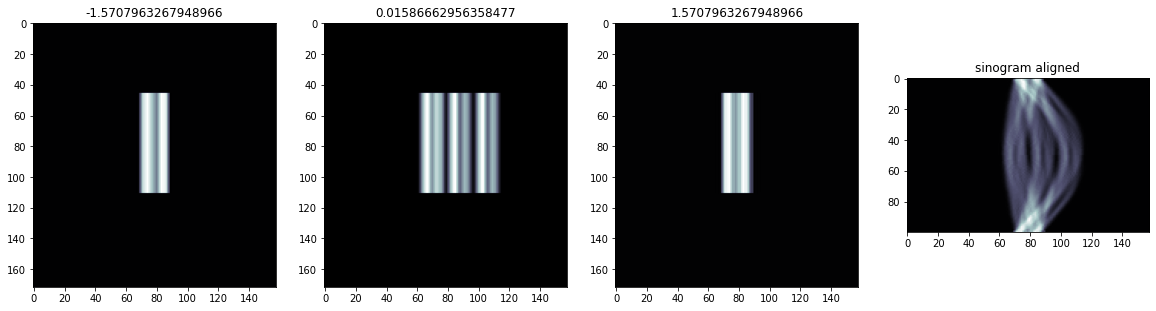

In [ ]:
fig, axs = plt.subplots(1,4,figsize = (20,60))
axs[0].imshow(sinogram[np.argsort(angles)[0]],cmap='bone')
axs[0].set_title(f"{angles[np.argsort(angles)[0]]}")
axs[1].imshow(sinogram[np.argsort(angles)[N_projections//2]],cmap='bone')
axs[1].set_title(f"{angles[np.argsort(angles)[N_projections//2]]}")        
axs[2].imshow(sinogram[np.argsort(angles)[N_projections - 1]],cmap='bone')
axs[2].set_title(f"{angles[np.argsort(angles)[N_projections - 1]]}")  
axs[3].imshow(np.sum(sinogram, axis = 1),cmap='bone')
axs[3].set_title(f"sinogram aligned")    
plt.show()

### Final recon

In [18]:
dic = {}
dic['gpu'] = [0]
dic["beta/delta"] =  0
dic["filter"] = 'hann'
dic["padding"] = 0
dic["blocksize"]  = 10
dic["method"] = 'eEMRT'
dic["iterations"] = 4
dic["beamgeometry"] = 'parallel'
#dic["interpolation"] = 'nearest' 
dic['detectorPixel[m]'] = 1
dic['interpolation'] = 'bilinear'
dic['flat'] = np.ones((sinogram[0]).shape)

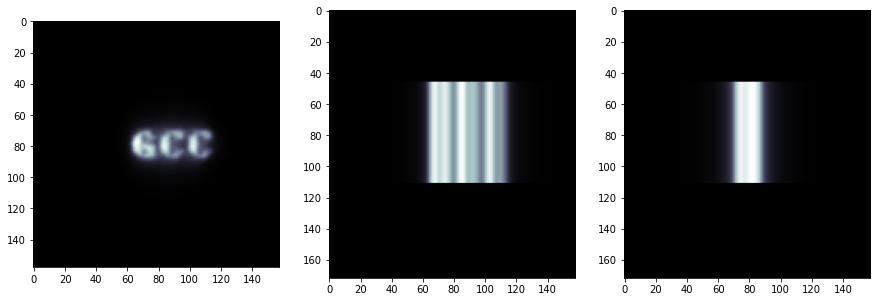

In [19]:
recon3D = sscRaft.em(np.swapaxes(sinogram,0,1), angles = angles, flat = np.ones((sinogram[0]).shape) ,dic = dic)

# visu support 
fig, axs = plt.subplots(1,3, figsize=(15,7));
axs[0].imshow(recon3D.sum(0),cmap='bone');
# axs[0].axis('off');
axs[1].imshow(recon3D.sum(1),cmap='bone');
# axs[1].axis('off');
axs[2].imshow(recon3D.sum(2),cmap='bone');
# axs[2].axis('off');
plt.show()